# **Generative Adverserial Network; From Data to Dollars: Using GANs to Generate Bags for Your Online Shop**

**Spring 2023, 
Course: Imaging for Security Applications**

**J.-L. Dugelay, Sahar Husseini **

**Student(s) name:** Julie E. Schult


**General instructions**

- Send the complete notebook with your answers (in English) before **April 21th**. 

- Remember to indicate your name & surname at the beginning of the notebook.

-  The code of the notebook has to run. If it presents compilation errors the student will be asked to submit a new running version and will be penalized.

**Challenge description**
The goal of this project is to familiarize you with Generative Adversarial Networks (GAN) architecture and to improve the model's architecture to generate better images. You will be working with the Fashion MNIST dataset and trying to produce realistic bags for your online shop.
- In this script you find all the parts related to GAN architecture. First run the code with the initial architecture and parameters and then your task is to change network's layers and hyper-parameters to improve generator's performance such that it generate more realistic images.

# Installation
You need to install matplotlib, tqdm, torchvision and torch. If you are going to use gpu, remember to install torch with gpu. (Optional: If you are going to use cpu in windows, you can use the requirement.txt file and anaconda for the installation.)

This code is based on pytorch. If you are not familiar with pytorch you can refer to the following links:

https://pytorch.org/tutorials/

https://pytorch.org/docs/stable/nn.html


In [1]:
#Important libraries to be imported
from os import makedirs
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import save_image
torch.manual_seed(0) # Set for testing purposes, please do not change!

# Visualization
You will use save_tensor_images_models function to visualize your generate images and save corresponding models. You do not need to modify this function.

In [2]:
def save_tensor_images_models(step, image_tensor, model, num_images=25, size=(1, 28, 28)):
    '''
    Function for saving generated images and models: Given a tensor of images, number of images, and
    size per image, save the image generated in specific step with the corresponding model.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    save_image(image_grid,'results_baseline/generated_plot_%03d.png' % (step) )
    torch.save(model.state_dict(), 'results_baseline/model_%03d.h5' % (step))

# Generator: 
The initial stage in developing the generator component involves the creation of a function that is capable of constructing a single layer or block for the neural network. This block is composed of a linear transformation operation that maps the input to another shape, a batch normalization procedure to enhance stability, and a non-linear activation function, namely Rectified Linear Unit (ReLU), that introduces non-linearity to the model. While future modifications to this block may be necessary to enhance performance, at this stage, it is recommended to maintain the block's current structure and avoid making any modifications.

In [3]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with two linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Linear(output_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

**The generator class can now be constructed by providing 3 values: (See next code section below)**

- The noise vector dimension (z_dim)
- The image dimension (im_dim)
- The initial hidden dimension (hidden_dim)

Using these values, the generator will build a neural network with 3 layers/blocks. Beginning with the noise vector, the generator will apply non-linear transformations via the block function until the tensor is mapped to the size of the image to be outputted (the same size as the real images from fashion MNIST). 

# your task:
- You will need to change generator's architecture to improve quality of the generated images. 


In [4]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (fashion MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Tanh()

        )
    def forward(self, noise):
        '''
        A forward pass function for the generator that takes a noise tensor as input and generates images as output.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

# Noise
To be able to use your generator, you will need to be able to create noise vectors. The noise vector z has the important role of making sure the images generated from the same class don't all look the same -- think of it as a random seed. You will generate it randomly using pyTorch by sampling random numbers from the normal distribution. Since multiple images will be processed per pass, you will generate all the noise vectors at once.
(You do not need to modify following function)

In [5]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    A function to create noise vectors that takes the dimensions (n_samples, z_dim) as input and generates a tensor of
    the same shape filled with random numbers drawn from a normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples,z_dim,device=device)


# Discriminator
To construct the second component, the discriminator, you will need to begin by creating a function that builds a neural network block for the discriminator. See below

In [6]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
    '''
    return nn.Sequential(
         nn.Linear(input_dim, output_dim), #Layer 1
         nn.LeakyReLU(0.2, inplace=True)
    )

**The discriminator class can now be constructed by providing 2 values: (See next code section below)**


- The image dimension (im_dim)
- The hidden dimension (hidden_dim)

The neural network for the discriminator, which take the image tensor as input and transform it until it produces a single numerical output, indicating whether the image is genuine or fake. 

# your task:
- You will need to change discriminator's architecture to help generator to generate better images. 

In [7]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 8),
            get_discriminator_block(hidden_dim * 8, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

# Training parameters
Now that you have defined the two network architectures, you can put it all together! First, you will set your parameters:

- criterion: the loss function
- n_epochs: the number of times you iterate through the entire dataset when training
- z_dim: the dimension of the noise vector
- display_step: how often to display/visualize the images
- batch_size: the number of images per forward/backward pass
- lr: the learning rate
- device: the device type, CPU or GPU

# your task:
- Change network hyper-parameters to improve your architecture performance



In [17]:
!rm -rf results_baseline

In [18]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss() 
n_epochs = 30 #10
z_dim = 128 #64
display_step = 11 #94
batch_size = 32 #128
lr = 0.001 #0.2
device = 'cpu'
#loading bag images from MNIST fashion dataset
dataset = FashionMNIST(root=".", transform=transforms.ToTensor(), download=True)
idx = dataset.targets==8
dataset.data = dataset.data[idx]
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


At this point, it's time to set up your generator, discriminator, and optimizers. Keep in mind that each optimizer is designed to optimize the parameters of a specific model, so you'll need to assign each optimizer to the appropriate model. This ensures that each optimizer only optimizes the model it's intended for.

In [19]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In preparation for GAN training, it's necessary to develop functions that can calculate the losses of both the discriminator and the generator. These loss functions serve as a feedback mechanism for the discriminator and generator to evaluate their performance and improve. However, because the generator is involved in calculating the discriminator's loss, it's important to use the .detach() method to prevent the generator's parameters from being updated during this step.

In [20]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #1) Create noise vectors and generate a batch (num_images) of fake images. 
    fake_noise = get_noise(num_images, z_dim, device=device)
    #2) Get the discriminator's prediction of the fake image 
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a 
    #            'ground truth' tensor in order to calculate the loss. 
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())   #remember to detach
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    # 3) Get the discriminator's prediction of the real image and calculate the loss.
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    #4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

The next step is to define the generator loss. Here generator wants the discriminator to think that its fake images are real.

In [21]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    ''' 
    #1) Create noise vectors and generate a batch of fake images. 
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    #2) Get the discriminator's prediction of the fake image.
    disc_fake_pred = disc(fake)
    #3) Calculate the generator's loss. Generator wants
    #          the discriminator to think that its fake images are real
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

The next function visualizes the loss values for the discriminator and generator. Later you can check these loss values to see if your model is training well. See "results_baseline" folder.

In [22]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist):
	# plot loss
	plt.plot(d_hist, label='disc-loss')
	plt.plot(g_hist, label='gen-loss')
	plt.legend()
	# save plot to file
	plt.savefig('results_baseline/plot_line_loss.png')
	plt.close()

Once you have reached this point, you are ready to integrate all the components together. In each epoch, the entire dataset will be processed in batches, and for each batch, you will need to update the discriminator and generator using their respective loss functions. These batches are sets of images that will be predicted on before the loss functions are calculated, which can result in a loss greater than 1 due to the binary cross entropy loss function.

It is common for the discriminator to initially outperform the generator since its task is simpler. However, it is important to prevent either model from achieving near-perfect accuracy, which would halt learning. Achieving a balance between the two models can be challenging in a standard GAN.





In [23]:


# make folder for results
makedirs('results_baseline', exist_ok=True)
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False
error = False
d_hist, g_hist = list(), list()

for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        ### Update generator ###
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        
        # summarize loss on this batch
		    # record history
        d_hist.append(disc_loss.item())
        g_hist.append(gen_loss.item())

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            save_tensor_images_models(cur_step,fake, model = gen)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
#save loss curves
plot_history(d_hist, g_hist)
  

  0%|          | 0/188 [00:00<?, ?it/s]

Step 11: Generator loss: 1.2765393690629439, discriminator loss: 0.7006638266823508
Step 22: Generator loss: 6.9286697127602315, discriminator loss: 0.2543905851515857
Step 33: Generator loss: 29.36601656133479, discriminator loss: 0.05300900221548297
Step 44: Generator loss: 53.47388961098411, discriminator loss: 0.13256053753535857
Step 55: Generator loss: 60.839749769731, discriminator loss: 0.014004746414932679
Step 66: Generator loss: 100.581411188299, discriminator loss: 0.0033061749682846394
Step 77: Generator loss: 183.95798561789772, discriminator loss: 0.0014484796265605837
Step 88: Generator loss: 197.7634374445135, discriminator loss: 0.006660071878947995
Step 99: Generator loss: 167.15076515891334, discriminator loss: 0.06488948914920911
Step 110: Generator loss: 74.21575130115856, discriminator loss: 0.9201725146709081
Step 121: Generator loss: 86.34892827814275, discriminator loss: 0.1234940015685259
Step 132: Generator loss: 67.27962251143022, discriminator loss: 0.3578

  0%|          | 0/188 [00:00<?, ?it/s]

Step 198: Generator loss: 29.802154107527304, discriminator loss: 0.016194575158310312
Step 209: Generator loss: 31.623639106750485, discriminator loss: 0.10968400218354707
Step 220: Generator loss: 14.341693184592506, discriminator loss: 0.2072575529190627
Step 231: Generator loss: 14.671175349842418, discriminator loss: 0.24797269905155353
Step 242: Generator loss: 31.259305867281824, discriminator loss: 0.15453408201309768
Step 253: Generator loss: 45.392976240678266, discriminator loss: 0.1465851588344032
Step 264: Generator loss: 19.461978478865195, discriminator loss: 0.19505633515390483
Step 275: Generator loss: 11.612837531349875, discriminator loss: 0.4469740973277525
Step 286: Generator loss: 14.503337296572598, discriminator loss: 0.2326346510513262
Step 297: Generator loss: 12.661598639054732, discriminator loss: 0.14617723565209997
Step 308: Generator loss: 9.68971027027477, discriminator loss: 0.18200652606107973
Step 319: Generator loss: 25.756532192230228, discriminator

  0%|          | 0/188 [00:00<?, ?it/s]

Step 385: Generator loss: 21.010626446117055, discriminator loss: 0.7377507212487134
Step 396: Generator loss: 7.16668590632352, discriminator loss: 0.24881541017781605
Step 407: Generator loss: 7.742108301682904, discriminator loss: 0.1905909976498647
Step 418: Generator loss: 8.399850498546254, discriminator loss: 0.4403029219670729
Step 429: Generator loss: 12.303195043043656, discriminator loss: 0.34203896806998685
Step 440: Generator loss: 31.53022454001687, discriminator loss: 0.08939813619310207
Step 451: Generator loss: 71.38766652887517, discriminator loss: 0.15440132181075486
Step 462: Generator loss: 78.22934341430664, discriminator loss: 0.32400829598984937
Step 473: Generator loss: 19.27560554851185, discriminator loss: 0.5025070111521265
Step 484: Generator loss: 18.999254573475227, discriminator loss: 0.034318159884688525
Step 495: Generator loss: 16.46694027293812, discriminator loss: 0.6963620345023546
Step 506: Generator loss: 32.16494490883567, discriminator loss: 0.

  0%|          | 0/188 [00:00<?, ?it/s]

Step 572: Generator loss: 19.252450682900168, discriminator loss: 0.21963829140771515
Step 583: Generator loss: 21.240719621831722, discriminator loss: 0.4109382324598052
Step 594: Generator loss: 12.290549711747605, discriminator loss: 0.33757358992641623
Step 605: Generator loss: 11.123190836472945, discriminator loss: 0.07641149151392959
Step 616: Generator loss: 9.669660915027965, discriminator loss: 0.13876877420327882
Step 627: Generator loss: 19.640770088542588, discriminator loss: 1.1734503372149034
Step 638: Generator loss: 17.081067345359106, discriminator loss: 0.08520340411500497
Step 649: Generator loss: 15.40270744670521, discriminator loss: 1.0948916917497462
Step 660: Generator loss: 4.455637346614491, discriminator loss: 0.8888936042785645
Step 671: Generator loss: 6.820912187749689, discriminator loss: 0.3549303656274622
Step 682: Generator loss: 4.389963865280151, discriminator loss: 0.1532623828812079
Step 693: Generator loss: 10.725041259418836, discriminator loss:

  0%|          | 0/188 [00:00<?, ?it/s]

Step 759: Generator loss: 12.151216637004506, discriminator loss: 0.282085659829053
Step 770: Generator loss: 24.404437672008168, discriminator loss: 0.0302351991307329
Step 781: Generator loss: 21.35068520632657, discriminator loss: 0.7211244552163407
Step 792: Generator loss: 9.523804447867654, discriminator loss: 0.1978484615683556
Step 803: Generator loss: 9.724316120147705, discriminator loss: 0.14678675884550266
Step 814: Generator loss: 6.291948253458196, discriminator loss: 1.2511119625785136
Step 825: Generator loss: 3.720580924641002, discriminator loss: 0.2540595924312418
Step 836: Generator loss: 8.44144886190241, discriminator loss: 0.07470944422212512
Step 847: Generator loss: 9.55541833964261, discriminator loss: 0.41517948968843976
Step 858: Generator loss: 7.092348142103717, discriminator loss: 1.0708116130395369
Step 869: Generator loss: 7.01712400263006, discriminator loss: 0.25199650769883936
Step 880: Generator loss: 5.199138663031838, discriminator loss: 0.3224644

  0%|          | 0/188 [00:00<?, ?it/s]

Step 946: Generator loss: 6.253449244932694, discriminator loss: 0.039529482601210475
Step 957: Generator loss: 6.339477940039201, discriminator loss: 0.15237926370040936
Step 968: Generator loss: 6.438453695990822, discriminator loss: 0.2835512919859453
Step 979: Generator loss: 10.372559070587156, discriminator loss: 0.2108991156247529
Step 990: Generator loss: 12.557540199973365, discriminator loss: 0.03313474882055412
Step 1001: Generator loss: 13.8514779697765, discriminator loss: 0.026172520931471478
Step 1012: Generator loss: 13.489927898753773, discriminator loss: 0.04446066784757105
Step 1023: Generator loss: 13.147459463639693, discriminator loss: 0.1317098012024706
Step 1034: Generator loss: 9.972795269706035, discriminator loss: 0.2753320349888368
Step 1045: Generator loss: 12.405247168107467, discriminator loss: 0.14480352943593805
Step 1056: Generator loss: 9.96106954054399, discriminator loss: 0.2892582809383219
Step 1067: Generator loss: 9.342955762689764, discriminator

  0%|          | 0/188 [00:00<?, ?it/s]

Step 1133: Generator loss: 11.99958272413774, discriminator loss: 0.18688467784192075
Step 1144: Generator loss: 7.506113854321566, discriminator loss: 0.08497895393520594
Step 1155: Generator loss: 5.124255982312289, discriminator loss: 0.5354934795336289
Step 1166: Generator loss: 5.870583447543058, discriminator loss: 0.18746641075069254
Step 1177: Generator loss: 6.05650672045621, discriminator loss: 0.12141834267161108
Step 1188: Generator loss: 5.190371990203857, discriminator loss: 0.3559976599433206
Step 1199: Generator loss: 3.496176091107455, discriminator loss: 0.39365484226833686
Step 1210: Generator loss: 6.012991948561235, discriminator loss: 0.2430234917185523
Step 1221: Generator loss: 9.757645216855137, discriminator loss: 0.06716239994222467
Step 1232: Generator loss: 10.6727463982322, discriminator loss: 0.04100509851493619
Step 1243: Generator loss: 15.189545891501687, discriminator loss: 0.059566762975671074
Step 1254: Generator loss: 16.962497624483973, discrimina

  0%|          | 0/188 [00:00<?, ?it/s]

Step 1320: Generator loss: 4.978855631568215, discriminator loss: 0.14951891147277568
Step 1331: Generator loss: 6.671017278324474, discriminator loss: 0.6653196066617966
Step 1342: Generator loss: 2.773445790464228, discriminator loss: 0.513603612780571
Step 1353: Generator loss: 4.305967526002364, discriminator loss: 0.14614696258848364
Step 1364: Generator loss: 6.675119985233653, discriminator loss: 0.03898157670416615
Step 1375: Generator loss: 7.790584347464821, discriminator loss: 0.10586774891073053
Step 1386: Generator loss: 8.236021345311945, discriminator loss: 0.14077164740724998
Step 1397: Generator loss: 8.770027334039861, discriminator loss: 0.3460853160782294
Step 1408: Generator loss: 8.471968000585383, discriminator loss: 0.2263280187140812
Step 1419: Generator loss: 8.190447720614346, discriminator loss: 0.5179395919496362
Step 1430: Generator loss: 5.7065723159096455, discriminator loss: 0.2387130389159376
Step 1441: Generator loss: 3.877345193516124, discriminator 

  0%|          | 0/188 [00:00<?, ?it/s]

Step 1507: Generator loss: 5.758770921013573, discriminator loss: 0.22457968511364676
Step 1518: Generator loss: 10.046961134130305, discriminator loss: 0.21333135935393244
Step 1529: Generator loss: 8.260748408057474, discriminator loss: 0.26439945806156506
Step 1540: Generator loss: 6.294120636853305, discriminator loss: 0.5062148869037628
Step 1551: Generator loss: 4.68120551109314, discriminator loss: 0.1598525900732387
Step 1562: Generator loss: 3.4600517099553896, discriminator loss: 0.7237038612365723
Step 1573: Generator loss: 2.5976768190210517, discriminator loss: 0.4629738872701472
Step 1584: Generator loss: 5.730497425252741, discriminator loss: 0.23099745810031896
Step 1595: Generator loss: 4.67757248878479, discriminator loss: 0.5364179367368872
Step 1606: Generator loss: 6.769961313767866, discriminator loss: 0.3190670623020692
Step 1617: Generator loss: 3.653497890992598, discriminator loss: 0.5980752543969589
Step 1628: Generator loss: 4.719680222597989, discriminator 

  0%|          | 0/188 [00:00<?, ?it/s]

Step 1694: Generator loss: 4.126743620092219, discriminator loss: 0.3840663121505217
Step 1705: Generator loss: 7.731381286274303, discriminator loss: 0.375160199674693
Step 1716: Generator loss: 9.213090809908781, discriminator loss: 0.4494703412055969
Step 1727: Generator loss: 4.678921591151845, discriminator loss: 0.195755140686577
Step 1738: Generator loss: 3.243745348670266, discriminator loss: 0.14940957318652762
Step 1749: Generator loss: 3.216845111413435, discriminator loss: 0.30683139102025464
Step 1760: Generator loss: 3.06917387788946, discriminator loss: 0.3123766793446107
Step 1771: Generator loss: 3.495164513587951, discriminator loss: 0.3456603207371451
Step 1782: Generator loss: 4.1813904155384405, discriminator loss: 0.5401395030997016
Step 1793: Generator loss: 4.074804663658142, discriminator loss: 0.6305434497242624
Step 1804: Generator loss: 6.943204532970081, discriminator loss: 0.08854481340809302
Step 1815: Generator loss: 3.8937254277142612, discriminator los

  0%|          | 0/188 [00:00<?, ?it/s]

Step 1881: Generator loss: 3.712815750728954, discriminator loss: 0.5590075064789164
Step 1892: Generator loss: 2.279932650652799, discriminator loss: 0.22562877698378134
Step 1903: Generator loss: 2.924516981298273, discriminator loss: 0.4539764807982879
Step 1914: Generator loss: 2.0840974612669516, discriminator loss: 0.5105454542420127
Step 1925: Generator loss: 1.8682954636487092, discriminator loss: 0.4559796208685095
Step 1936: Generator loss: 2.867192636836659, discriminator loss: 0.33751749992370605
Step 1947: Generator loss: 3.263848521492698, discriminator loss: 0.39097149534658954
Step 1958: Generator loss: 3.5106291879307143, discriminator loss: 0.3176464126868681
Step 1969: Generator loss: 3.8884072954004467, discriminator loss: 0.33897199955853546
Step 1980: Generator loss: 3.45074818351052, discriminator loss: 0.41660054569894617
Step 1991: Generator loss: 3.8821610754186455, discriminator loss: 0.33485565266825934
Step 2002: Generator loss: 3.759304350072687, discrimin

  0%|          | 0/188 [00:00<?, ?it/s]

Step 2068: Generator loss: 3.23994779586792, discriminator loss: 0.4134550500999798
Step 2079: Generator loss: 3.061368161981756, discriminator loss: 0.26070186360315845
Step 2090: Generator loss: 2.1928386904976582, discriminator loss: 0.3623211302540519
Step 2101: Generator loss: 2.332882046699524, discriminator loss: 0.3335404409603639
Step 2112: Generator loss: 3.397264578125694, discriminator loss: 0.4338634528897025
Step 2123: Generator loss: 3.157271558588202, discriminator loss: 0.43338505788282916
Step 2134: Generator loss: 2.866937193003568, discriminator loss: 0.4207830496809699
Step 2145: Generator loss: 3.0008046301928437, discriminator loss: 0.38819684765555645
Step 2156: Generator loss: 1.8134656711058186, discriminator loss: 0.36800896579569037
Step 2167: Generator loss: 2.491277781399813, discriminator loss: 0.47799850322983484
Step 2178: Generator loss: 2.0381478721445254, discriminator loss: 0.3895458551970395
Step 2189: Generator loss: 1.7512762221423064, discrimina

  0%|          | 0/188 [00:00<?, ?it/s]

Step 2266: Generator loss: 1.512908393686468, discriminator loss: 0.4310198615897785
Step 2277: Generator loss: 2.3569778095592153, discriminator loss: 0.331386841156266
Step 2288: Generator loss: 2.7742850130254575, discriminator loss: 0.35765081102197827
Step 2299: Generator loss: 3.7206566550514912, discriminator loss: 0.3502950532869859
Step 2310: Generator loss: 5.715737266974015, discriminator loss: 0.34002685275944794
Step 2321: Generator loss: 4.033156806772406, discriminator loss: 0.426626899025657
Step 2332: Generator loss: 3.9968235275962134, discriminator loss: 0.32179375670172944
Step 2343: Generator loss: 4.243765007365833, discriminator loss: 0.1828436539931731
Step 2354: Generator loss: 4.441737781871449, discriminator loss: 0.5468321293592453
Step 2365: Generator loss: 3.6328343911604444, discriminator loss: 0.4886527833613482
Step 2376: Generator loss: 2.035950844938105, discriminator loss: 0.7263073785738513
Step 2387: Generator loss: 2.6308116479353467, discriminato

  0%|          | 0/188 [00:00<?, ?it/s]

Step 2453: Generator loss: 4.987024534832347, discriminator loss: 0.3022489520636472
Step 2464: Generator loss: 3.981168351390145, discriminator loss: 0.8038121488961306
Step 2475: Generator loss: 10.641270940276709, discriminator loss: 0.7895415127277374
Step 2486: Generator loss: 7.709948843175714, discriminator loss: 0.5711789673024956
Step 2497: Generator loss: 3.7746263850818984, discriminator loss: 0.46717142245986243
Step 2508: Generator loss: 4.549303488297896, discriminator loss: 0.2806958569721742
Step 2519: Generator loss: 5.422886068170721, discriminator loss: 0.33743356032805005
Step 2530: Generator loss: 5.306387467817826, discriminator loss: 0.3513181792064146
Step 2541: Generator loss: 3.5606220743872905, discriminator loss: 0.6349571834911
Step 2552: Generator loss: 2.0114482857964253, discriminator loss: 0.4745186973701824
Step 2563: Generator loss: 2.550590460950678, discriminator loss: 0.3616693290797146
Step 2574: Generator loss: 2.072240276770158, discriminator lo

  0%|          | 0/188 [00:00<?, ?it/s]

Step 2640: Generator loss: 1.9208460504358464, discriminator loss: 0.44659954580393707
Step 2651: Generator loss: 2.7364572069861675, discriminator loss: 0.25745118206197565
Step 2662: Generator loss: 2.137589866464788, discriminator loss: 0.42025566913864826
Step 2673: Generator loss: 4.012927402149547, discriminator loss: 0.3119912215254524
Step 2684: Generator loss: 3.399499958211725, discriminator loss: 0.13640918616544115
Step 2695: Generator loss: 5.634969223629344, discriminator loss: 0.48064933717250824
Step 2706: Generator loss: 2.3067930990999392, discriminator loss: 0.5858592851595446
Step 2717: Generator loss: 1.8720004883679475, discriminator loss: 0.37240484627810383
Step 2728: Generator loss: 1.970657337795604, discriminator loss: 0.7720312530344183
Step 2739: Generator loss: 1.4491152600808577, discriminator loss: 0.4615604728460312
Step 2750: Generator loss: 3.5133239897814663, discriminator loss: 0.22011794014410535
Step 2761: Generator loss: 3.8502167138186367, discr

  0%|          | 0/188 [00:00<?, ?it/s]

Step 2827: Generator loss: 3.4807512109929863, discriminator loss: 0.26220130920410156
Step 2838: Generator loss: 3.3558384938673544, discriminator loss: 0.36339558796449145
Step 2849: Generator loss: 3.7705803242596714, discriminator loss: 0.6127924892035397
Step 2860: Generator loss: 2.663167064840143, discriminator loss: 0.5324783867055721
Step 2871: Generator loss: 3.0127686153758653, discriminator loss: 0.40363008867610584
Step 2882: Generator loss: 3.68576361916282, discriminator loss: 0.4755513342944058
Step 2893: Generator loss: 2.3974817070094026, discriminator loss: 0.6359270187941464
Step 2904: Generator loss: 2.093174522573298, discriminator loss: 0.4657301577654752
Step 2915: Generator loss: 1.8717915578321977, discriminator loss: 0.48681236397136335
Step 2926: Generator loss: 2.3567858175797896, discriminator loss: 0.3647607483647086
Step 2937: Generator loss: 1.9420487230474295, discriminator loss: 0.41208915276960895
Step 2948: Generator loss: 1.8632206374948674, discri

  0%|          | 0/188 [00:00<?, ?it/s]

Step 3014: Generator loss: 4.034161415967074, discriminator loss: 0.397712152112614
Step 3025: Generator loss: 6.04291296005249, discriminator loss: 0.7945854636755857
Step 3036: Generator loss: 3.355135527524081, discriminator loss: 0.33865820277820935
Step 3047: Generator loss: 2.459454428065907, discriminator loss: 0.537484662099318
Step 3058: Generator loss: 2.1182870214635674, discriminator loss: 0.4551971067081799
Step 3069: Generator loss: 1.7812895991585471, discriminator loss: 0.35786059769717127
Step 3080: Generator loss: 2.0293286388570615, discriminator loss: 0.2821718088605187
Step 3091: Generator loss: 2.8106663552197544, discriminator loss: 0.28456262024966156
Step 3102: Generator loss: 3.2219646302136513, discriminator loss: 0.3448723432692614
Step 3113: Generator loss: 2.6512725786729296, discriminator loss: 0.6496568566018885
Step 3124: Generator loss: 4.484330567446621, discriminator loss: 0.22498405657031317
Step 3135: Generator loss: 3.8273178230632436, discriminat

  0%|          | 0/188 [00:00<?, ?it/s]

Step 3201: Generator loss: 1.7590827833522449, discriminator loss: 0.35216741399331525
Step 3212: Generator loss: 2.1448607228019023, discriminator loss: 0.2480445612560619
Step 3223: Generator loss: 3.4206125519492407, discriminator loss: 0.287982776761055
Step 3234: Generator loss: 2.7222689281810415, discriminator loss: 0.2614848708564585
Step 3245: Generator loss: 3.919655615633184, discriminator loss: 0.609187819740989
Step 3256: Generator loss: 4.750435222278942, discriminator loss: 0.3387576402588324
Step 3267: Generator loss: 4.585033568468961, discriminator loss: 0.7446893128481779
Step 3278: Generator loss: 1.4368271881883794, discriminator loss: 0.5192931673743507
Step 3289: Generator loss: 1.7022030028429902, discriminator loss: 0.3253218721259724
Step 3300: Generator loss: 2.7762876098806206, discriminator loss: 0.2611885260451924
Step 3311: Generator loss: 2.8270563320680098, discriminator loss: 0.26638160239566455
Step 3322: Generator loss: 2.7675296501679854, discrimina

  0%|          | 0/188 [00:00<?, ?it/s]

Step 3388: Generator loss: 3.7777388962832363, discriminator loss: 0.22133948315273633
Step 3399: Generator loss: 3.8111894943497395, discriminator loss: 0.11792775311253288
Step 3410: Generator loss: 3.1050007018175996, discriminator loss: 0.9990441311489453
Step 3421: Generator loss: 3.5815436948429453, discriminator loss: 0.3471301509575411
Step 3432: Generator loss: 6.143288005482066, discriminator loss: 0.23785824972120198
Step 3443: Generator loss: 8.459174221212214, discriminator loss: 0.4419062327254902
Step 3454: Generator loss: 3.273965445431796, discriminator loss: 0.6297209127382799
Step 3465: Generator loss: 1.552050850608132, discriminator loss: 0.5278332585638219
Step 3476: Generator loss: 2.397585847161033, discriminator loss: 0.5798907388340343
Step 3487: Generator loss: 2.2690594521435825, discriminator loss: 0.5738289545882832
Step 3498: Generator loss: 4.205855391242287, discriminator loss: 0.24386661906134
Step 3509: Generator loss: 3.7350184732455425, discriminato

  0%|          | 0/188 [00:00<?, ?it/s]

Step 3575: Generator loss: 4.808006373318759, discriminator loss: 0.6178107126192613
Step 3586: Generator loss: 3.3539102077484135, discriminator loss: 0.7302842844616283
Step 3597: Generator loss: 3.2624764008955522, discriminator loss: 0.49073941057378595
Step 3608: Generator loss: 4.240766676989469, discriminator loss: 0.4722034280950373
Step 3619: Generator loss: 4.6894190961664375, discriminator loss: 0.47920253601941193
Step 3630: Generator loss: 6.183778611096468, discriminator loss: 0.3426367135887797
Step 3641: Generator loss: 4.85568404197693, discriminator loss: 0.23397733203389426
Step 3652: Generator loss: 2.618086283857172, discriminator loss: 0.6435530402443626
Step 3663: Generator loss: 4.226734811609441, discriminator loss: 0.2729920054023916
Step 3674: Generator loss: 4.960405046289617, discriminator loss: 0.247540798376907
Step 3685: Generator loss: 7.450559681112115, discriminator loss: 0.5172130777077242
Step 3696: Generator loss: 2.3947067369114268, discriminator 

  0%|          | 0/188 [00:00<?, ?it/s]

Step 3762: Generator loss: 7.311034896157005, discriminator loss: 0.2878797223622148
Step 3773: Generator loss: 3.387816169045189, discriminator loss: 0.6178221729668703
Step 3784: Generator loss: 2.594400037418712, discriminator loss: 0.41918282075361774
Step 3795: Generator loss: 2.8744879744269634, discriminator loss: 0.39350442046468903
Step 3806: Generator loss: 2.206897719339891, discriminator loss: 0.5076060864058408
Step 3817: Generator loss: 3.4325033426284786, discriminator loss: 0.45754011246291076
Step 3828: Generator loss: 4.3335369716991075, discriminator loss: 0.32282148098403757
Step 3839: Generator loss: 5.559926119717684, discriminator loss: 0.22101234373721212
Step 3850: Generator loss: 2.980823056264357, discriminator loss: 0.5658687461506237
Step 3861: Generator loss: 2.499087192795493, discriminator loss: 0.3370593942024492
Step 3872: Generator loss: 3.5256649147380483, discriminator loss: 0.6974665739319541
Step 3883: Generator loss: 2.39499446478757, discriminat

  0%|          | 0/188 [00:00<?, ?it/s]

Step 3949: Generator loss: 4.42987334728241, discriminator loss: 0.790974042632363
Step 3960: Generator loss: 3.2025544372471897, discriminator loss: 0.40585243431004614
Step 3971: Generator loss: 2.2278294454921377, discriminator loss: 0.6461647613482042
Step 3982: Generator loss: 2.2241981896487153, discriminator loss: 0.44566006823019544
Step 3993: Generator loss: 2.5441865054043857, discriminator loss: 0.24398974396965722
Step 4004: Generator loss: 2.8876555507833306, discriminator loss: 0.34554191881960084
Step 4015: Generator loss: 2.3871717154979706, discriminator loss: 0.41385194794698194
Step 4026: Generator loss: 2.457726077599959, discriminator loss: 0.19750237126242026
Step 4037: Generator loss: 2.9619785438884394, discriminator loss: 0.1158353601667014
Step 4048: Generator loss: 2.628941991112449, discriminator loss: 0.31087725067680533
Step 4059: Generator loss: 1.946842464533719, discriminator loss: 0.28761633417823096
Step 4070: Generator loss: 4.045507322658192, discri

  0%|          | 0/188 [00:00<?, ?it/s]

Step 4136: Generator loss: 4.376435084776445, discriminator loss: 0.1497519375248389
Step 4147: Generator loss: 4.623699188232422, discriminator loss: 0.39052195982499555
Step 4158: Generator loss: 4.530806476419623, discriminator loss: 0.349599689245224
Step 4169: Generator loss: 6.240878170186822, discriminator loss: 0.32037168470295996
Step 4180: Generator loss: 5.1153693632646045, discriminator loss: 0.2550218152728948
Step 4191: Generator loss: 4.589677962389859, discriminator loss: 0.9248682016676123
Step 4202: Generator loss: 2.221316911957481, discriminator loss: 0.5035720264369792
Step 4213: Generator loss: 2.7017858028411865, discriminator loss: 0.3852990093556317
Step 4224: Generator loss: 2.013733657923612, discriminator loss: 0.8856729052283546
Step 4235: Generator loss: 1.1593025706031106, discriminator loss: 0.5766474414955486
Step 4246: Generator loss: 2.396593408151106, discriminator loss: 0.31599324670704926
Step 4257: Generator loss: 2.9848605285991314, discriminator

  0%|          | 0/188 [00:00<?, ?it/s]

Step 4334: Generator loss: 2.49261935190721, discriminator loss: 0.4783657735044306
Step 4345: Generator loss: 3.311371933330189, discriminator loss: 0.30014360357414593
Step 4356: Generator loss: 2.7212846170772207, discriminator loss: 0.47801811586726795
Step 4367: Generator loss: 3.132803353396329, discriminator loss: 0.4744579439813441
Step 4378: Generator loss: 2.4228337678042324, discriminator loss: 0.40171129053289234
Step 4389: Generator loss: 2.7127026861364194, discriminator loss: 0.3040361986918883
Step 4400: Generator loss: 3.2109426910226992, discriminator loss: 0.556083611466668
Step 4411: Generator loss: 3.6454768180847164, discriminator loss: 0.46734688498757104
Step 4422: Generator loss: 4.200195399197665, discriminator loss: 0.25611765276301995
Step 4433: Generator loss: 5.290632139552724, discriminator loss: 0.19336685402826828
Step 4444: Generator loss: 4.241676157171076, discriminator loss: 0.5138894482092423
Step 4455: Generator loss: 1.856338977813721, discrimina

  0%|          | 0/188 [00:00<?, ?it/s]

Step 4521: Generator loss: 5.011073242534291, discriminator loss: 0.3007103597575968
Step 4532: Generator loss: 6.408880883997137, discriminator loss: 0.45399013872851024
Step 4543: Generator loss: 3.146113124760715, discriminator loss: 0.395032907074148
Step 4554: Generator loss: 2.5373334776271474, discriminator loss: 0.23610994219779968
Step 4565: Generator loss: 2.3232337344776504, discriminator loss: 0.27759553492069244
Step 4576: Generator loss: 3.0946494557640776, discriminator loss: 0.33194412968375464
Step 4587: Generator loss: 3.315713579004461, discriminator loss: 0.40190286663445557
Step 4598: Generator loss: 3.232205152511596, discriminator loss: 0.2620706802064723
Step 4609: Generator loss: 5.17636734789068, discriminator loss: 0.36995409361340786
Step 4620: Generator loss: 2.7873184301636433, discriminator loss: 0.9096991853280502
Step 4631: Generator loss: 5.135934591293335, discriminator loss: 0.24607017974961887
Step 4642: Generator loss: 2.9592136253010137, discrimin

  0%|          | 0/188 [00:00<?, ?it/s]

Step 4708: Generator loss: 2.0216024897315283, discriminator loss: 0.47938685525547375
Step 4719: Generator loss: 2.1929103894667192, discriminator loss: 0.39322390610521485
Step 4730: Generator loss: 2.413258704272183, discriminator loss: 0.4375114440917969
Step 4741: Generator loss: 1.859306183728305, discriminator loss: 0.36808242581107403
Step 4752: Generator loss: 2.1472519744526255, discriminator loss: 0.5536547384478829
Step 4763: Generator loss: 1.422192324291576, discriminator loss: 0.7321545156565579
Step 4774: Generator loss: 1.9744695966893977, discriminator loss: 0.42927800525318494
Step 4785: Generator loss: 3.663446773182262, discriminator loss: 0.3686320564963601
Step 4796: Generator loss: 2.2740200324492017, discriminator loss: 0.6633029823953455
Step 4807: Generator loss: 1.9040620760484177, discriminator loss: 0.5242521979592063
Step 4818: Generator loss: 3.4325545917857774, discriminator loss: 0.37955373119224195
Step 4829: Generator loss: 2.1841914274475793, discri

  0%|          | 0/188 [00:00<?, ?it/s]

Step 4895: Generator loss: 3.713824315504594, discriminator loss: 0.36282348497347394
Step 4906: Generator loss: 3.2452138770710337, discriminator loss: 0.4241659492254257
Step 4917: Generator loss: 3.2523098858920005, discriminator loss: 0.35898960855874146
Step 4928: Generator loss: 3.292536973953247, discriminator loss: 0.30013884062116797
Step 4939: Generator loss: 3.919331463900479, discriminator loss: 0.23958196965130893
Step 4950: Generator loss: 5.266585913571444, discriminator loss: 0.4543736265464262
Step 4961: Generator loss: 4.297389799898322, discriminator loss: 0.28400081396102905
Step 4972: Generator loss: 3.187949754975059, discriminator loss: 0.5031253776767037
Step 4983: Generator loss: 3.8798091411590576, discriminator loss: 0.17425151101567524
Step 4994: Generator loss: 5.455938680605454, discriminator loss: 1.2363328547640282
Step 5005: Generator loss: 1.1197988255457445, discriminator loss: 0.9094185531139373
Step 5016: Generator loss: 3.284027999097651, discrimin

  0%|          | 0/188 [00:00<?, ?it/s]

Step 5082: Generator loss: 0.9691682728854092, discriminator loss: 0.6390720660036261
Step 5093: Generator loss: 1.1362969008359043, discriminator loss: 0.509318771687421
Step 5104: Generator loss: 1.5766892216422341, discriminator loss: 0.596382198008624
Step 5115: Generator loss: 1.970246650955894, discriminator loss: 0.533508303490552
Step 5126: Generator loss: 1.7779894633726645, discriminator loss: 0.3944859423420646
Step 5137: Generator loss: 2.077244205908342, discriminator loss: 0.450169482014396
Step 5148: Generator loss: 2.551761724732139, discriminator loss: 0.805682128125971
Step 5159: Generator loss: 1.8178166367790916, discriminator loss: 0.5325680402192202
Step 5170: Generator loss: 1.4704958200454712, discriminator loss: 0.424307105216113
Step 5181: Generator loss: 2.471997867931019, discriminator loss: 0.5844584486701272
Step 5192: Generator loss: 2.030849597670815, discriminator loss: 0.6241129284555262
Step 5203: Generator loss: 1.9697865247726445, discriminator loss

  0%|          | 0/188 [00:00<?, ?it/s]

Step 5269: Generator loss: 2.5279977971857246, discriminator loss: 0.5108455609191548
Step 5280: Generator loss: 2.0001969229091294, discriminator loss: 0.44244923510334716
Step 5291: Generator loss: 1.8112096353010698, discriminator loss: 0.5248309753157877
Step 5302: Generator loss: 1.5015595609491523, discriminator loss: 0.43947295167229394
Step 5313: Generator loss: 3.1502363681793213, discriminator loss: 0.4350433268330314
Step 5324: Generator loss: 2.844220334833319, discriminator loss: 0.6313778460025787
Step 5335: Generator loss: 2.404283111745661, discriminator loss: 0.5173883817412636
Step 5346: Generator loss: 1.4974650252949107, discriminator loss: 0.4499258615753867
Step 5357: Generator loss: 1.6326225237412886, discriminator loss: 0.38111470504240563
Step 5368: Generator loss: 1.722498351877386, discriminator loss: 0.48439082774248987
Step 5379: Generator loss: 1.4327399080449885, discriminator loss: 0.42039726539091626
Step 5390: Generator loss: 2.122929713942788, discri

  0%|          | 0/188 [00:00<?, ?it/s]

Step 5456: Generator loss: 1.2399594025178389, discriminator loss: 0.5214385905049064
Step 5467: Generator loss: 1.4388598095286977, discriminator loss: 0.3841982538049872
Step 5478: Generator loss: 2.111494519493797, discriminator loss: 0.37855763462456793
Step 5489: Generator loss: 1.9199057709087022, discriminator loss: 0.5055901516567577
Step 5500: Generator loss: 1.9335231455889612, discriminator loss: 0.42505927248434583
Step 5511: Generator loss: 1.8918932134454902, discriminator loss: 0.48938902941617096
Step 5522: Generator loss: 2.1304912242022427, discriminator loss: 0.46588901498100976
Step 5533: Generator loss: 2.1541910930113364, discriminator loss: 0.47043114629658783
Step 5544: Generator loss: 1.3986633474176582, discriminator loss: 0.568043744022196
Step 5555: Generator loss: 1.5990515405481511, discriminator loss: 0.45552400567314844
Step 5566: Generator loss: 1.7987251715226609, discriminator loss: 0.4022429477084767
Step 5577: Generator loss: 1.5464324192567305, dis

Finally with the current architecture your results look similar to the images below

![generated_plot_376.png](attachment:generated_plot_376.png)

# Your task:
- In this step save your generated images and the loss curves and put them in your report. In the report you need to explain why the results are not very realistic and what you are going to do to improve the results.
- start to tune your network parameters and change your network architecture to get more realistic images that you can use on your online shop. 
- explain all steps you used to improve your generator. Specially visualize your loss curve and explain when you have the best result.
- After the deadline choose your best generated image and upload it to the following folder **“synthesized_images”** in moodle. Remember to change the name of your image being same as your **"firstName_lastName"**.  After the deadline other students will evaluate your result subjectively. 



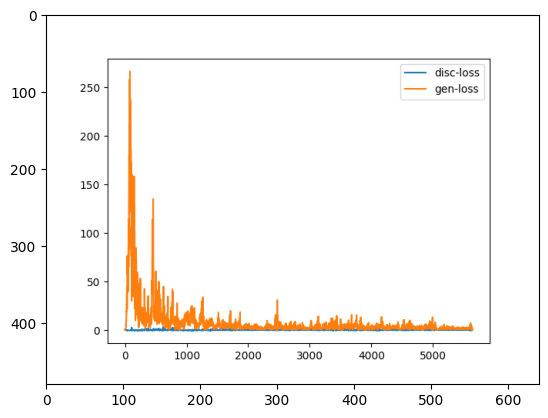

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('results_baseline/plot_line_loss.png')
imgplot = plt.imshow(img)
plt.show()